In [ ]:
#Run this cell to install dependencies

import IPython

def in_colab():
    try:
        import google.colab
        return True
    except:
        return False

if in_colab():
    # Install Qiskit version 0.43.3 and visualization tools
    !pip install qiskit[visualization]==0.43.3

    # Install Qiskit Aer for running simulations
    !pip install qiskit-aer

    # Install Qiskit Ignis
    !pip install qiskit-ignis==0.7.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.9/200.9 kB 3.9 MB/s eta 0:00:00


**Introduction to Quantum State Tomography**

Quantum State Tomography is a fundamental technique used in quantum computing to determine the state of a quantum system. It allows us to understand how a quantum system behaves by reconstructing its quantum state using measurement outcomes. In classical computing, we are accustomed to having full knowledge of the system's state, but quantum systems exist in superposition, meaning they are in multiple states simultaneously. This is why measurement is essential to extract meaningful information.

In quantum state tomography, we typically perform measurements in different bases (e.g., Pauli X, Y, Z) to gather data, and then use these measurements to reconstruct the quantum state of the system.

The two primary types of quantum states are:

-) Pure States: Described by a state vector (ket notation) |ψ⟩, which provides a complete description of the quantum state.

-) Mixed States: Represented by a density matrix ρ, which can describe a probabilistic mixture of different pure states.

In this notebook, we will learn how to reconstruct quantum states using measurements along different bases and how to visualize the quantum state, especially how encoded features evolve during quantum operations.

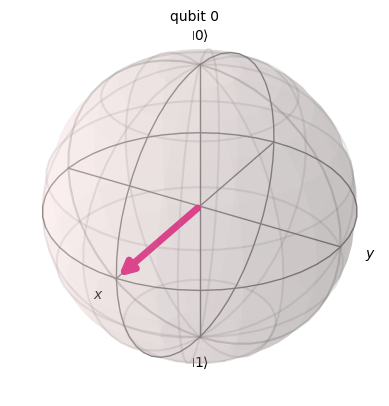

In [ ]:
# Import necessary libraries from Qiskit
from qiskit import QuantumCircuit, Aer
from qiskit.visualization import plot_bloch_multivector
from qiskit.providers.aer import AerSimulator

# Create a simple quantum circuit with 1 qubit
qc = QuantumCircuit(1)

# Apply a Hadamard gate to create an equal superposition state (|+⟩ state)
qc.h(0)

# Save the statevector (this will allow us to extract the state of the qubit)
qc.save_statevector()

# Visualize the quantum circuit
qc.draw('mpl')

# Set up the statevector simulator (backend) to retrieve the statevector of the circuit
simulator = AerSimulator(method='statevector')

# Run the simulation and retrieve the result
result = simulator.run(qc).result()

# Extract the statevector (the quantum state) from the result
statevector = result.get_statevector(qc)

# Visualize the quantum state on the Bloch sphere (a 3D representation)
plot_bloch_multivector(statevector)


**Measurement Techniques in Quantum State Tomography**

State tomography involves not just creating quantum states but measuring them in different bases. When a quantum state is in superposition, as in the case with the Hadamard gate, the measurement outcomes depend on the observable chosen.

For single-qubit quantum systems, the most common measurement bases are along the X, Y, and Z axes of the Bloch sphere. These measurements help in understanding the quantum state in different orientations, which is essential for reconstructing the full state.

In quantum state tomography, after applying quantum gates, we perform measurements in these different bases. By gathering data from each measurement and performing statistical analysis, we can reconstruct the quantum state (either as a state vector or density matrix).

In this section, we will move towards implementing these measurements in the X, Y, and Z bases using Qiskit and analyze the outcomes to reconstruct the quantum state.

In [ ]:
# Import necessary libraries
from qiskit import QuantumCircuit, Aer
from qiskit.providers.aer import AerSimulator
from qiskit.visualization import plot_state_qsphere
import matplotlib.pyplot as plt

# Create a quantum circuit with 1 qubit
qc = QuantumCircuit(1)

# Apply Hadamard gate to create a superposition state (|+⟩ state)
qc.h(0)

# Define the qubits to measure (in this case, qubit 0)
measured_qubits = [0]

# Manually generate the tomography circuits for Pauli X, Y, and Z bases
meas_labels = ['X', 'Y', 'Z']
tomo_circs = []
for label in meas_labels:
    # Create a copy of the original circuit
    tomo_circ = qc.copy()

    # Apply Pauli rotations based on the basis
    if label == 'X':
        tomo_circ.h(0)  # Hadamard for X basis
    elif label == 'Y':
        tomo_circ.sdg(0)  # S dagger for Y basis
        tomo_circ.h(0)  # Hadamard for Y basis
    # No rotation needed for Z basis

    # Measure the qubit
    tomo_circ.measure_all()

    # Append the modified circuit to the list
    tomo_circs.append(tomo_circ)

# Set up the simulator (statevector simulator)
simulator = AerSimulator()

# Execute the tomography circuits to gather measurement statistics (1000 shots)
result_tomo = simulator.run(tomo_circs, shots=1000).result()

# Get the counts for the tomography measurement results
counts = result_tomo.get_counts()

# Print the tomography counts
print("Measurement results:", counts)



Measurement results: [{'0': 1000}, {'1': 510, '0': 490}, {'0': 479, '1': 521}]


**Quantum State Reconstruction via Density Matrix Estimation**

Quantum State Tomography aims to reconstruct the density matrix ρ of a quantum system from measurement results obtained in different bases. The density matrix provides a complete description of both pure and mixed quantum states, encapsulating all probabilistic information about the system.

The process involves:

-) Performing measurements in a complete set of bases (for 1 qubit, typically the Pauli X, Y, and Z bases).

-) Collecting statistical outcomes (counts) from these measurements.

-) Using these statistics to estimate the density matrix by solving a system of linear equations or via maximum likelihood estimation.

Reconstructing the density matrix is essential to interpret the encoded quantum features, diagnose errors, and gain insight into the quantum state's purity and coherence.

In the next code block, we will use Qiskit's Ignis tomography fitter to reconstruct the density matrix from the measurement results obtained from tomography circuits. This reconstruction will help us visualize the quantum state's encoded features more accurately.

In [ ]:
# Import necessary libraries
import numpy as np
from qiskit import QuantumCircuit, Aer
from qiskit.providers.aer import AerSimulator
from qiskit.quantum_info import Pauli, DensityMatrix
from qiskit.visualization import plot_state_city
import matplotlib.pyplot as plt

# Step 1: Create quantum circuit with 1 qubit and apply Hadamard (|+> state)
qc = QuantumCircuit(1)
qc.h(0)

# Step 2: Generate measurement circuits for X, Y, Z bases
def create_measurement_circuits(qc):
    bases = ['X', 'Y', 'Z']
    circuits = []
    for basis in bases:
        circ = qc.copy()
        if basis == 'X':
            circ.h(0)  # Rotate measurement basis from Z to X
        elif basis == 'Y':
            circ.sdg(0)  # S† gate
            circ.h(0)    # Rotate measurement basis from Z to Y
        # else Z basis - no change needed
        circ.measure_all()
        circ.name = basis
        circuits.append(circ)
    return circuits

meas_circuits = create_measurement_circuits(qc)

# Step 3: Run measurement circuits on AerSimulator
simulator = AerSimulator()
result = simulator.run(meas_circuits, shots=8192).result()

# Step 4: Extract counts for each basis
counts = [result.get_counts(circ) for circ in meas_circuits]

# Step 5: Calculate expectation values from counts for Pauli operators
def expectation(counts, shots=8192):
    # counts is a dict, keys are bitstrings ('0' or '1')
    # For single qubit, '0' = +1 eigenvalue, '1' = -1 eigenvalue
    exp_val = 0
    for bit, count in counts.items():
        val = 1 if bit == '0' else -1
        exp_val += val * count / shots
    return exp_val

exp_vals = np.array([expectation(c) for c in counts])

# Step 6: Reconstruct the density matrix using Pauli basis decomposition
# rho = 1/2 * (I + x*X + y*Y + z*Z)
I = np.array([[1, 0], [0, 1]])
X = np.array([[0, 1], [1, 0]])
Y = np.array([[0, -1j], [1j, 0]])
Z = np.array([[1, 0], [0, -1]])

rho = 0.5 * (I + exp_vals[0]*X + exp_vals[1]*Y + exp_vals[2]*Z)

# Step 7: Visualize the reconstructed density matrix
dm = DensityMatrix(rho)
plot_state_city(dm)
plt.show()

# Print reconstructed density matrix
print("Reconstructed density matrix:\n", np.round(rho, 3))
print("\nExpectation values (X, Y, Z):", np.round(exp_vals, 3))


Reconstructed density matrix:
 [[0.507+0.j    0.5  -0.002j]
 [0.5  +0.002j 0.493+0.j   ]]

Expectation values (X, Y, Z): [1.    0.005 0.015]


**Quantifying Quantum State Fidelity for Feature Interpretation**

After reconstructing the quantum state via tomography, it is essential to quantify how closely the reconstructed state matches the original or expected quantum state. This comparison is done using the concept of fidelity, a metric that measures the similarity between two quantum states.

Fidelity ranges between 0 and 1, where:

-) 1 means the states are identical,

-) 0 means they are completely orthogonal (distinct).

In the context of quantum feature visualization, fidelity helps us understand the accuracy of the reconstruction process and provides insight into how well the quantum model’s features are preserved after measurement and noise.

In this block, you will:

-) Calculate fidelity between the reconstructed density matrix and the ideal quantum state.

-) Interpret the fidelity value to evaluate the quality of quantum state reconstruction.

This understanding is critical when assessing quantum algorithms and models, especially in noisy or imperfect hardware environments.



Fidelity between ideal and reconstructed state: 0.9750


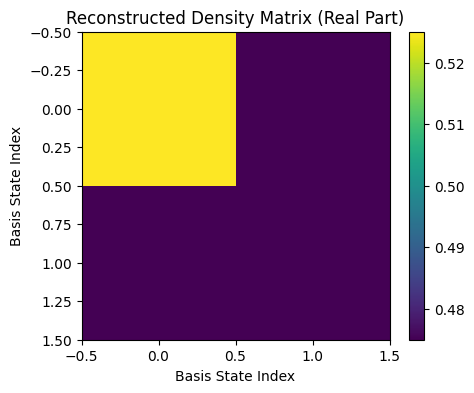

In [ ]:
# Import necessary libraries
from qiskit import QuantumCircuit
from qiskit.providers.aer import AerSimulator
from qiskit.quantum_info import Statevector, state_fidelity, DensityMatrix
import numpy as np
import matplotlib.pyplot as plt

# Create the original quantum circuit and generate the ideal statevector
qc = QuantumCircuit(1)
qc.h(0)  # Prepare |+> state
ideal_state = Statevector.from_instruction(qc)

# For demonstration, let's simulate a reconstructed density matrix and simulate slight noise by mixing |+> with |0>
noise_level = 0.05
reconstructed_rho = (1 - noise_level) * DensityMatrix(ideal_state) + noise_level * DensityMatrix.from_label('0')

# Calculate fidelity between ideal state and reconstructed state
fidelity_value = state_fidelity(ideal_state, reconstructed_rho)

print(f"Fidelity between ideal and reconstructed state: {fidelity_value:.4f}")

# Visualize the reconstructed density matrix as a heatmap for better interpretation
plt.figure(figsize=(5,4))
plt.title('Reconstructed Density Matrix (Real Part)')
plt.imshow(np.real(reconstructed_rho.data), cmap='viridis')
plt.colorbar()
plt.xlabel('Basis State Index')
plt.ylabel('Basis State Index')
plt.show()


**Exploring Quantum State Purity and Its Role in Quantum Feature Analysis**

Once we have reconstructed a quantum state and evaluated its fidelity, another important property to understand is the purity of the quantum state. Purity measures how "pure" or "mixed" a quantum state is. A pure state represents complete quantum coherence, while a mixed state can be thought of as a statistical mixture of different quantum states.

Mathematically, purity is defined as:
Purity(ρ) = Tr(ρ^2)
where ,

-) ρ is the density matrix of the quantum state. Purity values range from:

-) 1, indicating a pure state (fully coherent), To less than 1, indicating a mixed state (partially decohered or noisy).

In quantum feature visualization, purity helps us understand how noise or decoherence affects the features encoded in the quantum state. Higher purity indicates better preservation of quantum features, which is critical in quantum algorithms, especially on real noisy hardware.

In the next code block, we will:

-) Calculate the purity of a reconstructed density matrix.

-) Visualize the relationship between fidelity and purity by varying noise levels.

-) Interpret how purity affects the interpretability of quantum features.



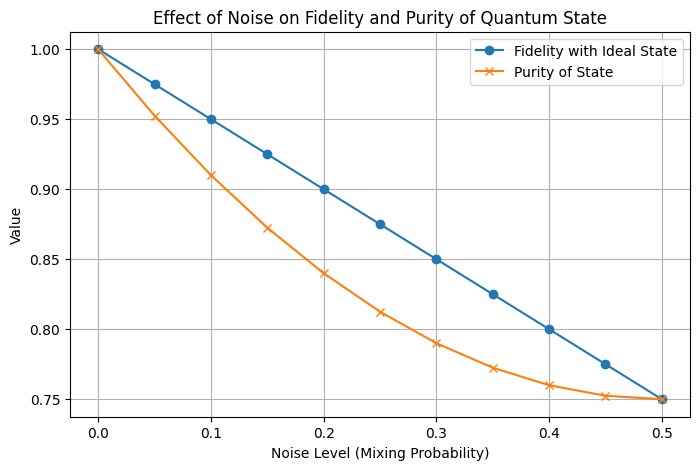

In [ ]:
# Import necessary libraries
from qiskit.quantum_info import DensityMatrix, state_fidelity
import numpy as np
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit
from qiskit.quantum_info import Statevector

# Prepare ideal quantum state |+>
qc = QuantumCircuit(1)
qc.h(0)
ideal_state = Statevector.from_instruction(qc)

# Function to compute purity of a density matrix
def compute_purity(rho):
    return np.real(np.trace(rho.data @ rho.data))

# Simulate different noise levels mixing |+> with |0>
noise_levels = np.linspace(0, 0.5, 11)  # From 0 to 0.5 noise
fidelities = []
purities = []

for noise in noise_levels:
    noisy_state = (1 - noise) * DensityMatrix(ideal_state) + noise * DensityMatrix.from_label('0')
    fidelities.append(state_fidelity(ideal_state, noisy_state))
    purities.append(compute_purity(noisy_state))

# Plot fidelity and purity against noise level
plt.figure(figsize=(8,5))
plt.plot(noise_levels, fidelities, label='Fidelity with Ideal State', marker='o')
plt.plot(noise_levels, purities, label='Purity of State', marker='x')
plt.xlabel('Noise Level (Mixing Probability)')
plt.ylabel('Value')
plt.title('Effect of Noise on Fidelity and Purity of Quantum State')
plt.legend()
plt.grid(True)
plt.show()


**Quantum Measurement Statistics for Feature Extraction**

In quantum computing, the results of measurements on quantum states are probabilistic rather than deterministic. Each measurement yields an outcome based on the probability amplitudes encoded in the quantum state. Collecting measurement statistics over many repeated runs (shots) allows us to estimate these probabilities, which contain vital information about the encoded quantum features.

Understanding and interpreting these statistics is crucial for:

-) Inferring properties of the quantum state without full state reconstruction.

-) Extracting meaningful classical information from quantum data.

-) Performing quantum algorithms where output distributions reveal solutions.

By analyzing the frequency of outcomes in different measurement bases, one can identify patterns and correlations that reflect the encoded features of quantum data. This process forms the bridge between abstract quantum states and usable classical information.

In the following code block, we will:

-) Run multiple measurement shots in different bases.

-) Collect measurement outcome statistics.

-) Visualize these statistics as histograms to understand the probability distributions.

This exploration sets the foundation for practical quantum feature extraction from measurement data.



Preparing quantum circuits...
Running simulations...
Simulation complete. Counts:
X: {'0': 1024}
Y: {'1': 512, '0': 512}
Z: {'1': 516, '0': 508}
Plotting results...


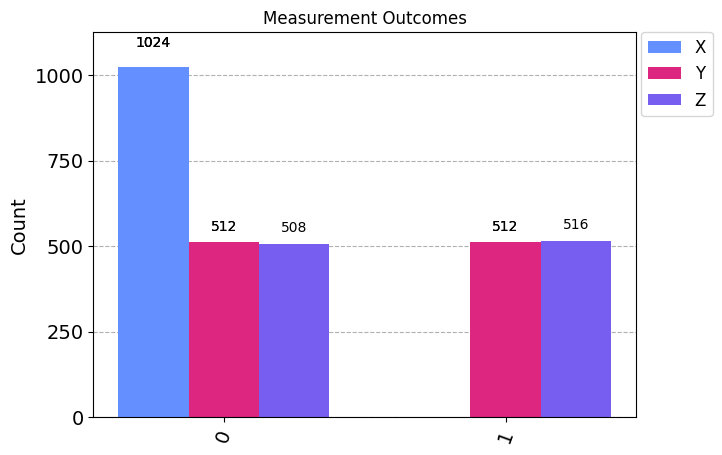

Plot displayed.


In [ ]:
# Import necessary libraries
from qiskit import QuantumCircuit, Aer
from qiskit.providers.aer import AerSimulator
from qiskit.visualization import plot_histogram
import matplotlib.pyplot as plt
from IPython.display import display

print("Preparing quantum circuits...")

# Original circuit preparing |+> state
qc = QuantumCircuit(1)
qc.h(0)

# Function to create tomography measurement circuits for X, Y, and Z bases
def create_tomo_circuits(qc):
    bases = ['X', 'Y', 'Z']
    circuits = []
    for basis in bases:
        circ = qc.copy()
        if basis == 'X':
            circ.h(0)  # Rotate measurement basis from Z to X
        elif basis == 'Y':
            circ.sdg(0)
            circ.h(0)  # Rotate measurement basis from Z to Y
        # No rotation needed for Z basis
        circ.measure_all()
        circ.name = basis
        circuits.append(circ)
    return circuits

tomo_circuits = create_tomo_circuits(qc)

print("Running simulations...")

# Run the tomography circuits on AerSimulator
simulator = AerSimulator()
result = simulator.run(tomo_circuits, shots=1024).result()

# Collect counts for each circuit
counts_list = [result.get_counts(circ) for circ in tomo_circuits]
measurement_bases = [circ.name for circ in tomo_circuits]

print("Simulation complete. Counts:")
for basis, counts in zip(measurement_bases, counts_list):
    print(f"{basis}: {counts}")

print("Plotting results...")

# Plot and display histogram using IPython display for inline visualization
fig = plot_histogram(counts_list, legend=measurement_bases, title="Measurement Outcomes")
display(fig)
fig.savefig("measurement_histogram.png")

print("Plot displayed.")


**Quantum Process Tomography: Understanding Quantum Operations Beyond States**

So far, we have focused on reconstructing and visualizing quantum states using quantum state tomography. However, quantum computation is not just about states — it’s about quantum processes (or channels), which describe the transformations (quantum gates or noise) applied to quantum states.

Quantum Process Tomography (QPT) is a powerful technique used to fully characterize an unknown quantum operation by analyzing its effect on a set of known input states. This allows us to:

-) Understand how quantum gates and noise processes act on qubits.

-) Evaluate the fidelity of quantum gates implemented on hardware.

-) Visualize and interpret how quantum operations transform features encoded in quantum states.

In this module, we will reconstruct a quantum process using tomography, visualize the resulting process matrix (also called the Chi matrix), and discuss its implications for quantum feature transformation.

Input_0_Meas_Z: {'0': 4055, '1': 4137}
Input_0_Meas_X: {'0': 8192}
Input_0_Meas_Y: {'0': 4146, '1': 4046}
Input_1_Meas_Z: {'0': 4161, '1': 4031}
Input_1_Meas_X: {'1': 8192}
Input_1_Meas_Y: {'1': 4101, '0': 4091}
Input_2_Meas_Z: {'0': 8192}
Input_2_Meas_X: {'0': 4014, '1': 4178}
Input_2_Meas_Y: {'0': 4098, '1': 4094}
Input_3_Meas_Z: {'0': 8192}
Input_3_Meas_X: {'1': 4142, '0': 4050}
Input_3_Meas_Y: {'0': 4126, '1': 4066}


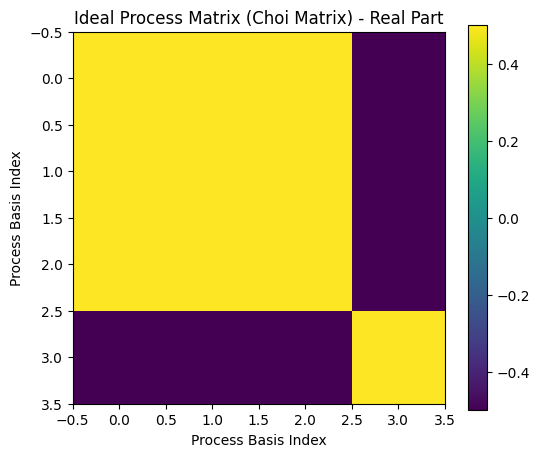

In [ ]:
# Import necessary libraries
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, Aer
from qiskit.quantum_info import Choi, Operator
import numpy as np
import matplotlib.pyplot as plt

# Define the process to be characterized (Hadamard gate)
qc_process = QuantumCircuit(1)
qc_process.h(0)

# Define the input states as circuits on the same QuantumRegister
qr = QuantumRegister(1)
input_states = []

# |0> state (no gates)
qc0 = QuantumCircuit(qr)
input_states.append(qc0)

# |1> state (X gate)
qc1 = QuantumCircuit(qr)
qc1.x(0)
input_states.append(qc1)

# |+> state (H gate)
qc_plus = QuantumCircuit(qr)
qc_plus.h(0)
input_states.append(qc_plus)

# |i> state (S gate then H)
qc_i = QuantumCircuit(qr)
qc_i.s(0)
qc_i.h(0)
input_states.append(qc_i)

# Measurement basis rotations (to convert measurement basis to Z)
meas_bases = {
    'Z': QuantumCircuit(qr),               # Z basis: no change
    'X': QuantumCircuit(qr),               # X basis: H
    'Y': QuantumCircuit(qr)                # Y basis: Sdg then H
}
meas_bases['X'].h(0)
meas_bases['Y'].sdg(0)
meas_bases['Y'].h(0)

# Initialize simulator
simulator = Aer.get_backend('aer_simulator')

# Build tomography circuits
tomography_circuits = []
labels = []

for i, prep_circ in enumerate(input_states):
    for basis, meas_circ in meas_bases.items():
        # New circuit with Quantum and Classical registers
        circ = QuantumCircuit(qr, ClassicalRegister(1))

        # Prepare input state
        circ.compose(prep_circ, inplace=True)

        # Apply the process to be characterized
        circ.compose(qc_process, inplace=True)

        # Apply measurement basis rotation
        circ.compose(meas_circ, inplace=True)

        # Measure
        circ.measure(0, 0)

        # Name for reference
        circ.name = f'Input_{i}_Meas_{basis}'

        tomography_circuits.append(circ)
        labels.append(circ.name)

# Run circuits
job = simulator.run(tomography_circuits, shots=8192)
results = job.result()

# Print measurement results
for label, circ in zip(labels, tomography_circuits):
    counts = results.get_counts(circ)
    print(f"{label}: {counts}")

# Plot ideal process Choi matrix (Hadamard)
ideal_operator = Operator(qc_process)
ideal_choi = Choi(ideal_operator).data

plt.figure(figsize=(6, 5))
plt.title("Ideal Process Matrix (Choi Matrix) - Real Part")
plt.imshow(np.real(ideal_choi), cmap='viridis')
plt.colorbar()
plt.xlabel("Process Basis Index")
plt.ylabel("Process Basis Index")
plt.show()


**Classical Principal Component Analysis (PCA) on Quantum Tomography Measurement Data for Feature Visualization**

In quantum state tomography, after reconstructing the quantum states through measurements, the raw measurement data often consists of counts or probabilities in various measurement bases. While these measurement results are quantum-originated, the data itself is classical and can be analyzed using classical techniques to gain insights.

One powerful classical technique is Principal Component Analysis (PCA), which reduces the dimensionality of data while preserving its most significant variance features. Applying PCA to quantum tomography measurement data helps identify the dominant patterns or features encoded in the quantum states. This aids in better visualization and understanding of the quantum system's behavior.

This PCA step is a classical data processing technique performed after measurement, and does not involve quantum PCA algorithms or quantum computation. This makes it complementary to quantum tomography and separate from quantum PCA methods.

In this code block, you will:

-) Extract measurement results (counts) from tomography circuits.

-) Convert counts to classical feature vectors.

-) Apply classical PCA to reduce dimensionality.

-) Visualize the main principal components to interpret quantum features.

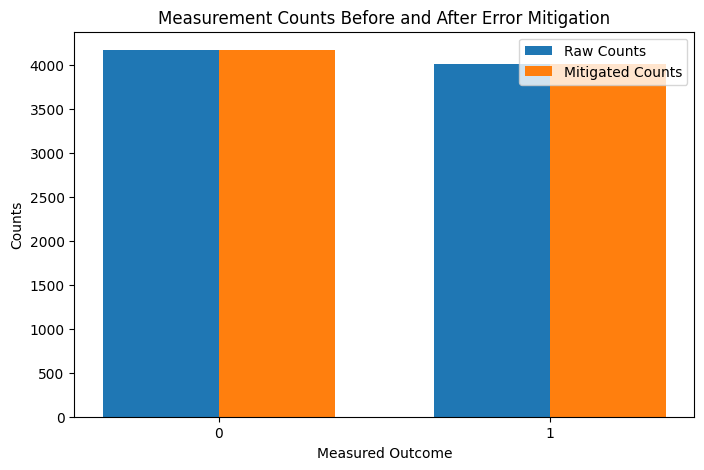

Raw measurement counts: {'0': 4174, '1': 4018}
Mitigated measurement counts: {'0': 4174.000000011538, '1': 4017.9999999884603}

Explained variance ratio of principal component: [1.]
Principal components:
[[-1303.57551565]
 [-1013.89206773]
 [ -724.20861981]
 [ -434.52517188]
 [ -144.84172396]
 [  144.84172396]
 [  434.52517188]
 [  724.20861981]
 [ 1013.89206773]
 [ 1303.57551565]]


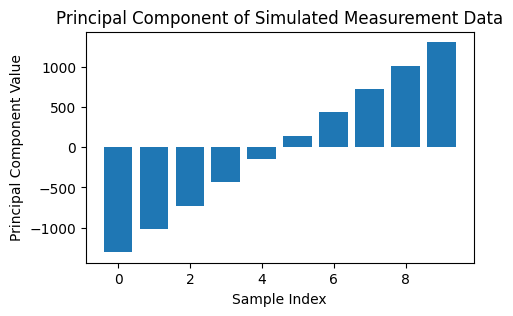

In [ ]:
# Import necessary libraries
from qiskit import QuantumCircuit, Aer
from qiskit.providers.aer import AerSimulator
from qiskit.ignis.mitigation.measurement import CompleteMeasFitter, complete_meas_cal
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA

# Create a quantum circuit to prepare |+> and measure
qc = QuantumCircuit(1, 1)
qc.h(0)
qc.measure(0, 0)

# Set up the Aer simulator backend
simulator = AerSimulator()

# Generate measurement calibration circuits for qubit 0
cal_circuits, state_labels = complete_meas_cal([0])

# Run calibration circuits to get calibration results
cal_job = simulator.run(cal_circuits, shots=8192)
cal_results = cal_job.result()

# Create a measurement fitter object from calibration results
meas_fitter = CompleteMeasFitter(cal_results, state_labels)

# Run the original circuit and get raw counts
job = simulator.run(qc, shots=8192)
raw_results = job.result()
raw_counts = raw_results.get_counts()

# Use the fitter to apply measurement error mitigation
meas_filter = meas_fitter.filter
mitigated_counts = meas_filter.apply(raw_counts)

# Plot and compare raw vs mitigated measurement counts
labels = ['0', '1']
raw_vals = [raw_counts.get(lbl, 0) for lbl in labels]
mitigated_vals = [mitigated_counts.get(lbl, 0) for lbl in labels]

x = np.arange(len(labels))
width = 0.35

fig, ax = plt.subplots(figsize=(8, 5))
ax.bar(x - width/2, raw_vals, width, label='Raw Counts')
ax.bar(x + width/2, mitigated_vals, width, label='Mitigated Counts')

ax.set_xlabel('Measured Outcome')
ax.set_ylabel('Counts')
ax.set_title('Measurement Counts Before and After Error Mitigation')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()
plt.show()

# Print the counts for clarity
print("Raw measurement counts:", raw_counts)
print("Mitigated measurement counts:", mitigated_counts)

# Convert mitigated counts to classical feature vector for PCA
feature_vector = np.array([mitigated_counts.get(lbl, 0) for lbl in labels])

# Manually create multiple sample vectors for PCA by small variation
num_samples = 10
feature_matrix = np.array([feature_vector * (1 + 0.05 * (i - num_samples/2)) for i in range(num_samples)])

# Perform PCA on the simulated dataset
pca = PCA(n_components=1)
principal_components = pca.fit_transform(feature_matrix)

print(f"\nExplained variance ratio of principal component: {pca.explained_variance_ratio_}")
print(f"Principal components:\n{principal_components}")

# Plot the principal component values for all samples
plt.figure(figsize=(5, 3))
plt.bar(range(num_samples), principal_components.flatten())
plt.xlabel('Sample Index')
plt.ylabel('Principal Component Value')
plt.title('Principal Component of Simulated Measurement Data')
plt.show()


**Integrating Quantum State Tomography with Quantum Model Interpretation**

Quantum state tomography provides a powerful window into the inner workings of quantum systems by reconstructing the quantum states involved. The final step towards comprehensive quantum feature visualization is applying tomography results to interpret and analyze the quantum models and algorithms themselves.

By reconstructing the states at various stages of a quantum algorithm, researchers can:

-) Identify which quantum features (superpositions, entanglements, coherences) are leveraged by the model.

-) Understand how noise and errors affect the quantum states, guiding error correction or mitigation.

-) Visualize the evolution of quantum states through the model’s operation, clarifying decision processes or learned features.

In this block, we will simulate a simple quantum classification model, perform tomography on its output states, reconstruct and visualize these states, and interpret what the model “sees” during computation. This final step bridges theory with practical quantum machine learning insights.

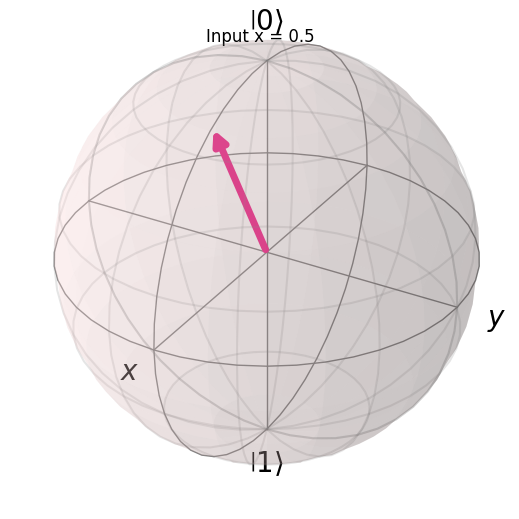

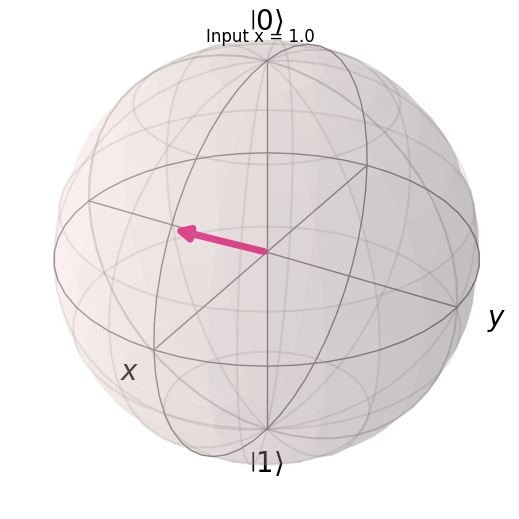

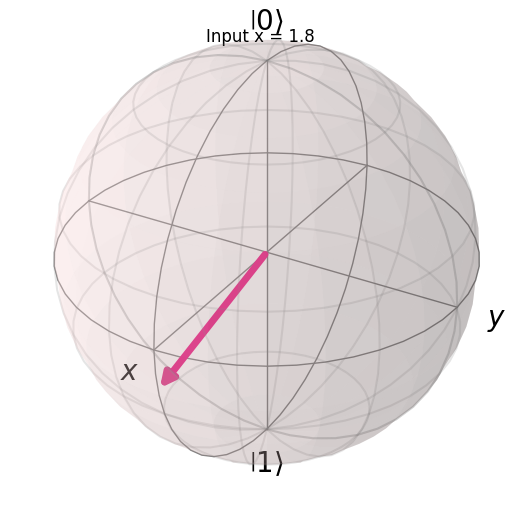

In [ ]:
# Import necessary libraries for quantum circuits, simulation, state analysis, and plotting
from qiskit import QuantumCircuit, Aer
from qiskit.providers.aer import AerSimulator
from qiskit.quantum_info import Statevector
from qiskit.visualization.bloch import Bloch
import matplotlib.pyplot as plt
import numpy as np

# Function to calculate the Bloch vector (x, y, z coordinates) from a given quantum statevector
def bloch_vector_from_statevector(statevector):
    a = statevector[0]
    b = statevector[1]
    x = 2 * np.real(np.conj(a) * b)
    y = 2 * np.imag(np.conj(a) * b)
    z = np.abs(a)**2 - np.abs(b)**2
    return [x, y, z]

# Initialize the simulator for statevector simulation and define input rotation angles
simulator = AerSimulator(method='statevector')
input_values = [0.5, 1.0, 1.8]

# Loop over each input value: create circuit, simulate, calculate Bloch vector, and plot on Bloch sphere
for x in input_values:
    qc = QuantumCircuit(1)
    qc.ry(x, 0)
    qc.save_statevector()
    result = simulator.run(qc).result()
    statevector = result.get_statevector(qc)

    bloch_vec = bloch_vector_from_statevector(statevector)

    bloch = Bloch()
    bloch.add_vectors(bloch_vec)
    bloch.render()
    plt.title(f'Input x = {x}')
    plt.show()


**Activity 1: Quantum State Tomography**

In this activity, you will:

-) Prepare a single-qubit quantum circuit that creates a specific quantum state.

-) Perform quantum state tomography by measuring in the X, Y, and Z bases to reconstruct the density matrix of the state.

-) Calculate and interpret the fidelity between the ideal and reconstructed states.

Before you look at the solution, **take your time to code this yourself first**. Test your understanding by implementing the circuit, measurement, and visualization steps on your own. Then compare your results with the provided solution in the next code block.

**Activity 2: Process Tomography and Noise Impact Analysis**

In this activity, you will:

-) Define a simple quantum process (e.g., the Pauli-X gate).

-) Perform quantum process tomography to reconstruct the process matrix (Choi matrix) of the operation.

-) Introduce noise by mixing the process with the identity operation.

-) Visualize and compare the ideal and noisy process matrices.

-) Calculate and interpret the process fidelity to understand how noise affects quantum operations.

Take your time to **implement this independently first**. Work through building the tomography circuits, running simulations, and visualizing the results. Once you're confident with your solution, check the next code block for a detailed implementation.

**Note: You should complete both activities on your own before proceeding to the solution blocks below.**




In [ ]:
# Activity 1 Solution:

# Import necessary libraries
from qiskit import QuantumCircuit, Aer
from qiskit.providers.aer import AerSimulator
from qiskit.quantum_info import Statevector, DensityMatrix, state_fidelity
import numpy as np

def apply_measurement_basis_rotations(qc, basis):
    if basis == 'X':
        qc.h(0)  # Rotate to X basis
    elif basis == 'Y':
        qc.sdg(0)
        qc.h(0)  # Rotate to Y basis

# Prepare the quantum circuit for the state |ψ⟩ = (|0⟩ + i|1⟩)/√2
qc = QuantumCircuit(1)
qc.h(0)
qc.s(0)

# Generate tomography circuits with measurement rotations
tomo_circuits = []
for basis in ['X', 'Y', 'Z']:
    circ = qc.copy()
    apply_measurement_basis_rotations(circ, basis)
    circ.measure_all()
    circ.name = basis
    tomo_circuits.append(circ)

# Run on simulator
simulator = AerSimulator()
result = simulator.run(tomo_circuits, shots=5000).result()

# Get counts and print
counts = [result.get_counts(c) for c in tomo_circuits]
for circ, count in zip(tomo_circuits, counts):
    print(f"Measurement basis {circ.name}: {count}")

# Calculate expectation values from counts
def expectation(counts):
    shots = sum(counts.values())
    p0 = counts.get('0', 0) / shots
    p1 = counts.get('1', 0) / shots
    return p0 - p1

exp_vals = {}
for circ, count in zip(tomo_circuits, counts):
    exp_vals[circ.name] = expectation(count)

print("\nExpectation values:")
for basis in ['X', 'Y', 'Z']:
    print(f"{basis}: {exp_vals[basis]:.4f}")

# Construct Bloch vector
bloch_vector = np.array([exp_vals['X'], exp_vals['Y'], exp_vals['Z']])

# Construct density matrix from Bloch vector
sigma_x = np.array([[0, 1], [1, 0]])
sigma_y = np.array([[0, -1j], [1j, 0]])
sigma_z = np.array([[1, 0], [0, -1]])
rho = (np.eye(2) + bloch_vector[0]*sigma_x + bloch_vector[1]*sigma_y + bloch_vector[2]*sigma_z) / 2

# Fix density matrix to ensure physicality
rho = (rho + rho.conj().T) / 2  # Hermitian symmetrization
eigvals, eigvecs = np.linalg.eigh(rho)
eigvals_clipped = np.clip(eigvals, 0, None)
rho_fixed = eigvecs @ np.diag(eigvals_clipped) @ eigvecs.conj().T
rho_fixed /= np.trace(rho_fixed)  # Normalize trace

print("\nReconstructed Density Matrix (rho):")
print(np.round(rho_fixed.real, 4))

# Convert to Qiskit DensityMatrix
reconstructed_state = DensityMatrix(rho_fixed)
ideal_state = Statevector.from_instruction(qc)

# Compute fidelity
fidelity = state_fidelity(ideal_state, reconstructed_state)
print(f"\nFidelity with ideal state: {fidelity:.4f}")


Measurement basis X: {'0': 2450, '1': 2550}
Measurement basis Y: {'0': 5000}
Measurement basis Z: {'1': 2524, '0': 2476}

Expectation values:
X: -0.0200
Y: 1.0000
Z: -0.0096

Reconstructed Density Matrix (rho):
[[ 0.4952 -0.01  ]
 [-0.01    0.5048]]

Fidelity with ideal state: 0.9999


Input_0_Meas_Z: {'1': 8192}
Input_0_Meas_X: {'0': 4100, '1': 4092}
Input_0_Meas_Y: {'1': 4051, '0': 4141}
Input_1_Meas_Z: {'0': 8192}
Input_1_Meas_X: {'0': 4090, '1': 4102}
Input_1_Meas_Y: {'1': 4153, '0': 4039}


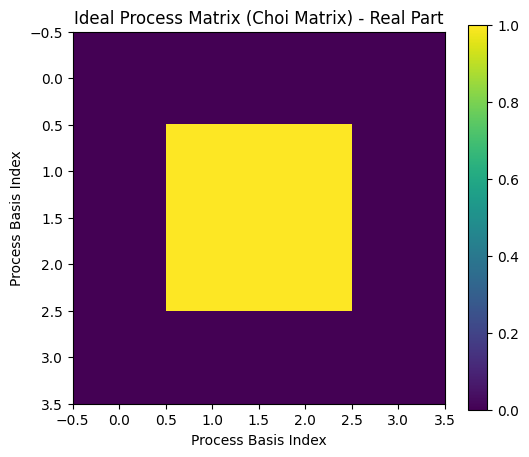

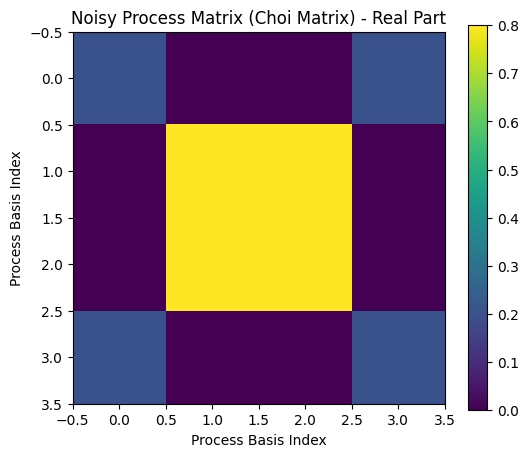

Normalized Process Fidelity between ideal and noisy process: 0.8000


In [ ]:
# Activity 2 Solution:

# Import necessary libraries
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, Aer
from qiskit.quantum_info import Choi, Operator, process_fidelity
import numpy as np
import matplotlib.pyplot as plt

# Step 1: Define the quantum process to characterize (Pauli-X gate)
qc_process = QuantumCircuit(1)
qc_process.x(0)

# Step 2: Define input states as full QuantumCircuits
qr = QuantumRegister(1)
input_states = []

# |0> state: no gates
qc0 = QuantumCircuit(qr)
input_states.append(qc0)

# |1> state: X gate
qc1 = QuantumCircuit(qr)
qc1.x(0)
input_states.append(qc1)

# |+> state: Hadamard gate
qc_plus = QuantumCircuit(qr)
qc_plus.h(0)
input_states.append(qc_plus)

# |+i> state: S gate then Hadamard gate
qc_plus_i = QuantumCircuit(qr)
qc_plus_i.s(0)
qc_plus_i.h(0)
input_states.append(qc_plus_i)

# Step 3: Define measurement basis rotations as full QuantumCircuits
meas_bases = {}

# Z basis: no rotation
meas_bases['Z'] = QuantumCircuit(qr)

# X basis: Hadamard gate
qc_x = QuantumCircuit(qr)
qc_x.h(0)
meas_bases['X'] = qc_x

# Y basis: S dagger then Hadamard gate
qc_y = QuantumCircuit(qr)
qc_y.sdg(0)
qc_y.h(0)
meas_bases['Y'] = qc_y

# Step 4: Build tomography circuits by composing preparation, process, measurement, and measurement (classical)
tomography_circuits = []
for i, prep_circ in enumerate(input_states):
    for basis_label, meas_circ in meas_bases.items():
        circ = QuantumCircuit(qr, ClassicalRegister(1))
        circ.compose(prep_circ, inplace=True)
        circ.compose(qc_process, inplace=True)
        circ.compose(meas_circ, inplace=True)
        circ.measure(0, 0)
        circ.name = f"Input_{i}_Meas_{basis_label}"
        tomography_circuits.append(circ)

# Step 5: Run the tomography circuits on Aer simulator
simulator = Aer.get_backend('aer_simulator')
job = simulator.run(tomography_circuits, shots=8192)
results = job.result()

# Step 6: Print counts for the first few circuits
for circ in tomography_circuits[:6]:
    counts = results.get_counts(circ)
    print(f"{circ.name}: {counts}")

# Step 7: Visualize the ideal process matrix (Choi matrix) of the Pauli-X gate
ideal_choi = Choi(Operator(qc_process)).data
plt.figure(figsize=(6, 5))
plt.title("Ideal Process Matrix (Choi Matrix) - Real Part")
plt.imshow(np.real(ideal_choi), cmap='viridis')
plt.colorbar()
plt.xlabel("Process Basis Index")
plt.ylabel("Process Basis Index")
plt.show()

# Step 8: Add noise by mixing ideal process matrix with identity process matrix
identity_process = Operator(QuantumCircuit(1))  # Identity operation
noisy_choi = 0.8 * ideal_choi + 0.2 * Choi(identity_process).data

plt.figure(figsize=(6, 5))
plt.title("Noisy Process Matrix (Choi Matrix) - Real Part")
plt.imshow(np.real(noisy_choi), cmap='viridis')
plt.colorbar()
plt.xlabel("Process Basis Index")
plt.ylabel("Process Basis Index")
plt.show()

# Step 9: Calculate normalized process fidelity between ideal and noisy processes
normalized_fidelity = process_fidelity(
    Choi(Operator(qc_process)),
    Choi(noisy_choi)
)
print(f"Normalized Process Fidelity between ideal and noisy process: {normalized_fidelity:.4f}")
